# Wind Turbine Accidents: A Data Mining Study

### Imports

In [1]:
import pandas as pd
#import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import scipy.stats as stats
import scipy.special as sp
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from statsmodels.graphics.mosaicplot import mosaic

In [58]:
raw_dataset = pd.read_csv('News.Database.csv')

In [3]:
pd.set_option('display.max_columns', None)

raw_dataset.head()

,Accident No,Accident type,Site/area\n,Country\n,Details\n,Web reference/link\n,Year,Month,Day,Turbine Type,Manufacturer,Power of Turbine (KW),PowerOfWindFarm (KW),Offshore,During Construction,FULL-DATE,Outcome,Death,Fire,Injury,Mechanical,Structural Break,Transport Accident,Component,Cause,CauseCategory,Source Database,Source of the News,Title of the article
0,1.0,Wind,Tjaereborg,Denmark,Damage to all 3 blades,http://www.modernpowersystems.com/story.asp?st...,2002,11,4,Vestas 2000 KW,Vestas,2000,19000,1,0,"April 11, 2002",Structural break,0.0,0.0,0.0,0.0,1.0,0.0,Blade,Human (interference in control systems),Human,LexisNexis,Major World Publications,Bending with the wind
1,2.0,Wind,Jiangsu,China,5 died & 4 injured workers,http://www.chinadaily.com.cn/china/2012-03/11/...,2012,3,10,UNKNOWN,UNKNOWN,UNKNOWN,5000,1,1,"October 3, 2012",Structural break,1.0,0.0,1.0,0.0,1.0,0.0,UNKNOWN,Mechanical (platform collapse at construction ...,Mechanical,LexisNexis,Modern Power System,Death toll in China construction site accident...
2,3.0,Wind,Ireland,UK,The turbine came loose after bolts attaching i...,http://www.modernpowersystems.com/story.asp?st...,2009,1,UNKNOWN,Enercon 2000 KW,Enercon,2000,4000,0,0,UNKNOWN,Structural break,0.0,0.0,0.0,1.0,1.0,0.0,Bolt,Mechanical (material fatigue),Mechanical,LexisNexis,The Sunday Telegraph,ET 'not to blame'
3,4.0,Wind,"Berwickshire, Scotland",UK,A 30m turbine near Coldingham was deliberately...,http://www.windbyte.co.uk/safety.html,2011,12,7,Hannevind 22 KW,Hannevind,22,UNKNOWN,0,0,"December 7, 2011",Mechanical,0.0,0.0,0.0,1.0,0.0,0.0,Tower,Mechanical ( blade system failure),Mechanical,Google,windbyte.co.uk,Wind turbine safety
4,5.0,Wind,Ohio,USA,The fallen wind turbine was supplying power to...,http://www.vindy.com/news/2011/apr/11/wind-tur...,2011,4,10,Proven 15 KW,Proven,15,45,0,0,"April 11, 2011",Structural break,0.0,0.0,0.0,0.0,1.0,0.0,Tower,UNKNOWN,UNKNOWN,LexisNexis,vindy.com,Wind turbine failure western reserve high scho...


In [4]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Accident No            273 non-null    float64
 1   Accident type          273 non-null    object 
 2   Site/area
             273 non-null    object 
 3   Country
               273 non-null    object 
 4   Details
               273 non-null    object 
 5   Web reference/link
    273 non-null    object 
 6   Year                   273 non-null    object 
 7   Month                  273 non-null    object 
 8   Day                    273 non-null    object 
 9   Turbine Type           273 non-null    object 
 10  Manufacturer           273 non-null    object 
 11  Power of Turbine (KW)  273 non-null    object 
 12  PowerOfWindFarm (KW)   273 non-null    object 
 13  Offshore               83 non-null     object 
 14  During Construction    83 non-null     object 
 15  FULL-D

In [59]:
raw_dataset['Afectted Humans'] =raw_dataset['Death'] + raw_dataset['Injury']
raw_dataset['Afectted Humans'] = raw_dataset['Afectted Humans'].map({2.0: 1.0, 1.0:1.0,0.0:0.0})

raw_dataset['Affected System/Equipment'] =raw_dataset['Fire'] + raw_dataset['Structural Break'] + raw_dataset['Transport Accident']
raw_dataset['Affected System/Equipment'] = raw_dataset['Affected System/Equipment'].map({3.0:1.0,2.0: 1.0, 1.0:1.0,0.0:0.0})

raw_dataset.columns = ['Onshore/Offshore' if x=='Offshore' else x for x in raw_dataset.columns]
raw_dataset['Onshore/Offshore'] = raw_dataset['Onshore/Offshore'].map({"1":"Offshore","0":"Onshore"})

raw_dataset = raw_dataset.drop('Accident No', axis=1)
raw_dataset = raw_dataset.drop('Accident type', axis=1) 
raw_dataset = raw_dataset.drop('Source Database', axis=1)
raw_dataset = raw_dataset.drop('Source of the News', axis=1)
raw_dataset = raw_dataset.drop('Title of the article', axis=1)
raw_dataset = raw_dataset.drop('Web reference/link\n', axis=1)

raw_dataset.columns = ['Site/area' if x=='Site/area\n' else x for x in raw_dataset.columns]
raw_dataset.columns = ['Country' if x=='Country\n' else x for x in raw_dataset.columns]
raw_dataset.columns = ['Details' if x=='Details\n' else x for x in raw_dataset.columns]
#raw_dataset.columns = ['Web reference/link' if x=='Web reference/link\n' else x for x in raw_dataset.columns]

raw_dataset['Onshore/Offshore'] = raw_dataset['Onshore/Offshore'].fillna("0")
raw_dataset['During Construction'] = raw_dataset['During Construction'].fillna("0")

df = raw_dataset.copy()

df.drop(df[df.isnull().sum(axis=1) > 7].index, inplace=True)

yDeath = df['Death']
yInjury = df['Injury']

df = df.drop('Death', axis=1)
df = df.drop('Injury', axis=1)

In [60]:
enc = OrdinalEncoder()
enc.fit(df[["Site/area","Country", "Details", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
df[["Site/area","Country", "Details", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]] = enc.transform(df[["Site/area","Country", "Details", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
for cols in df.columns :
    df[cols] = (df[cols] - min(df[cols]))/( max(df[cols]) - min(df[cols]))

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 272
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Site/area                  273 non-null    object 
 1   Country                    273 non-null    object 
 2   Details                    273 non-null    object 
 3   Year                       273 non-null    object 
 4   Month                      273 non-null    object 
 5   Day                        273 non-null    object 
 6   Turbine Type               273 non-null    object 
 7   Manufacturer               273 non-null    object 
 8   Power of Turbine (KW)      273 non-null    object 
 9   PowerOfWindFarm (KW)       273 non-null    object 
 10  Onshore/Offshore           273 non-null    object 
 11  During Construction        273 non-null    object 
 12  FULL-DATE                  273 non-null    object 
 13  Outcome                    273 non-null    object 

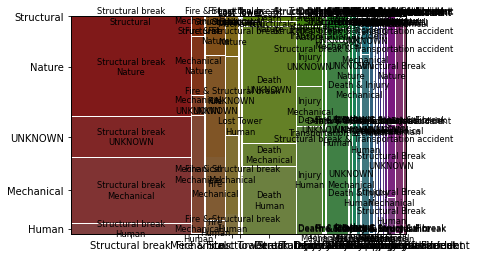

In [76]:
mosaic_df = raw_dataset[['CauseCategory', 'Outcome']].copy()
mosaic_df['Deaths'] = yDeath

mosaic(data=mosaic_df, index=['Outcome', 'CauseCategory'])
plt.show()

In [79]:
raw_dataset.Outcome.unique()

array(['Structural break', 'Mechanical', 'Fire',
       'Fire & Structural break', 'Lost Tower', 'Death', 'Injury',
       'Death & Fire', 'Transportation accident', 'UNKNOWN', 'Ice throw',
       'Death & Injury', 'Structural break & Transportation accident ',
       'Bird injury', 'Death & Transportation accident', 'Fire & Injury',
       'Fire & Injury & Structural break',
       'Injury & Transportation accident', 'Death & Injury & Fire',
       'Structural Break', 'Bird death', 'Death ', nan], dtype=object)

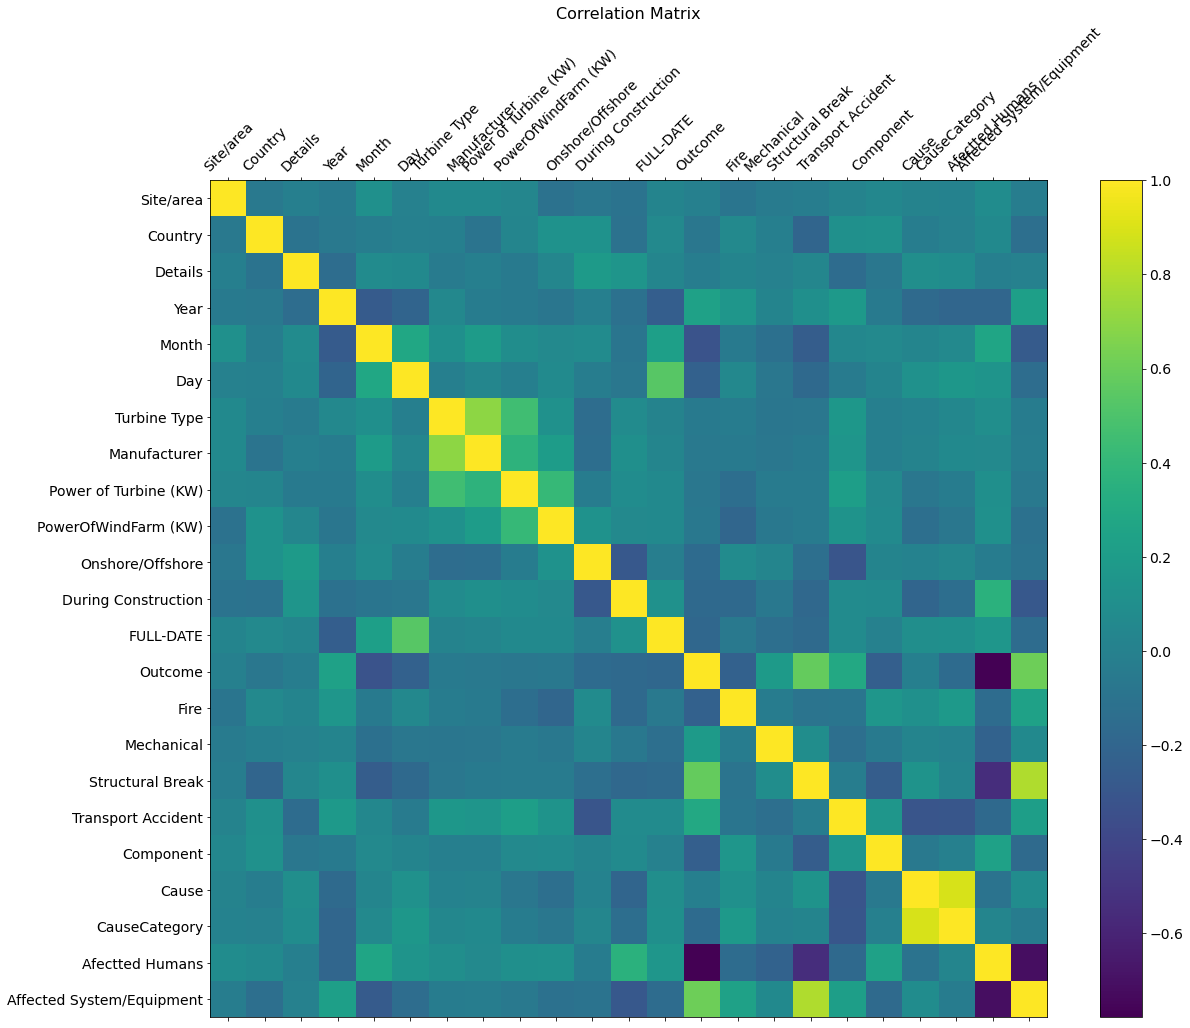

In [10]:

cr_mtx = df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(cr_mtx, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [11]:
upper = cr_mtx.where(np.triu(np.ones(cr_mtx.shape), k=1).astype(np.bool))
cr_mtx = upper.fillna(0)

/tmp/ipykernel_3747/1926744448.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = cr_mtx.where(np.triu(np.ones(cr_mtx.shape), k=1).astype(np.bool))


In [12]:
lst = list(cr_mtx.columns.values)
c = []
for i in lst:
    for j in lst:
        if i != j and (cr_mtx[i][j] >= 0.2 or cr_mtx[i][j] <= -0.2) :
            c.append({i,j})

c            

[{'Month', 'Year'},
 {'Day', 'Year'},
 {'Day', 'Month'},
 {'Manufacturer', 'Turbine Type'},
 {'Power of Turbine (KW)', 'Turbine Type'},
 {'Manufacturer', 'Power of Turbine (KW)'},
 {'Manufacturer', 'PowerOfWindFarm (KW)'},
 {'Power of Turbine (KW)', 'PowerOfWindFarm (KW)'},
 {'During Construction', 'Onshore/Offshore'},
 {'FULL-DATE', 'Year'},
 {'FULL-DATE', 'Month'},
 {'Day', 'FULL-DATE'},
 {'Outcome', 'Year'},
 {'Month', 'Outcome'},
 {'Day', 'Outcome'},
 {'Fire', 'Outcome'},
 {'Month', 'Structural Break'},
 {'Outcome', 'Structural Break'},
 {'Power of Turbine (KW)', 'Transport Accident'},
 {'Onshore/Offshore', 'Transport Accident'},
 {'Outcome', 'Transport Accident'},
 {'Component', 'Outcome'},
 {'Component', 'Structural Break'},
 {'Cause', 'Transport Accident'},
 {'CauseCategory', 'Transport Accident'},
 {'Cause', 'CauseCategory'},
 {'Afectted Humans', 'Month'},
 {'Afectted Humans', 'During Construction'},
 {'Afectted Humans', 'Outcome'},
 {'Afectted Humans', 'Mechanical'},
 {'Afectt

In [13]:
StatisticalTest = pd.DataFrame(columns=['Test No', 'Attribute1','Attribute2', 'Correlation', 'Test Performed' ,'p-Value', 'Result'])

for x in c :
    #print(x.pop() + "  " + x.pop())
    a = x.pop()
    b =x.pop()
    if  raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.object :
        ok = "-"
        #res = stats.fisher_exact(pd.crosstab(df[a], df[b], margins = False))
        #res = stats.fisher_exact(df[[a, b]])
        #if res[1] < 0.05 :
        #    ok = "-"  
        #else :
        #    ok = "+"
        #StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "Fisher’s Test" , res[1], ok]
        
    elif raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.float64 :
        
        dfDropNa = df.dropna()
        
        res = stats.chi2_contingency(pd.crosstab(dfDropNa[a], dfDropNa[b], margins = False))
        if res[1] < 0.05 :
            ok = "-"  
        else :
            ok = "+"
        StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "Chi Square Pearson Test" , res[1], ok]
        
    elif (raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.object) or (raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.float64):
        dfDropNa = df.dropna()     
        
        res = stats.shapiro(dfDropNa[[a, b]])
        if res[1] < 0.05 : 
            res1 = stats.ttest_ind(dfDropNa[a], dfDropNa[b])
            if res1[1] < 0.05 :
                    ok = "-"  
            else :
                ok = "+"
            StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "T-Test" , res[1], ok]
        else :
            res1 = stats.kruskal(dfDropNa[a], dfDropNa[b])
            if res1[1] < 0.05 :
                    ok = "-"  
            else :
                ok = "+"
            StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "Kruskal-Wallis Test" , res[1], ok]
    
StatisticalTest.sort_values('Correlation',ascending=[False] )

/tmp/ipykernel_3747/2047656282.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if  raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.object :
/tmp/ipykernel_3747/2047656282.py:28: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif (raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.object) or (raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.float64):


,Test No,Attribute1,Attribute2,Correlation,Test Performed,p-Value,Result
18,0,Affected System/Equipment,Outcome,0.605040,T-Test,4.115123e-16,-
2,0,Structural Break,Outcome,0.577698,T-Test,1.509480e-15,+
10,0,Afectted Humans,During Construction,0.356176,T-Test,3.349045e-21,-
5,0,Transport Accident,Outcome,0.294711,T-Test,4.297016e-16,-
9,0,Afectted Humans,Month,0.266614,T-Test,3.035832e-14,+
3,0,Transport Accident,Power of Turbine (KW),0.215851,T-Test,4.469606e-15,-
21,0,Affected System/Equipment,Transport Accident,0.215729,Chi Square Pearson Test,8.217505e-01,+
12,0,Mechanical,Afectted Humans,0.000000,Chi Square Pearson Test,9.528623e-01,+
19,0,Fire,Affected System/Equipment,0.000000,Chi Square Pearson Test,1.071930e-01,+
15,0,Year,Affected System/Equipment,0.000000,T-Test,3.950081e-18,+


In [14]:
RankingD = pd.DataFrame(columns=['Attribute', 'Values', 'Information Gain'])
i = 1

for cols in df.columns :
    res = sp.kl_div(df[cols] , yDeath)
    res = [x for x in res if str(x) != 'nan']
    res = [x for x in res if str(x) != 'inf']
    row = {'Attribute':cols, 'Values':max(Counter(res).values()), 'Information Gain':sum(res)/len(res)}
    RankingD = RankingD.append(row, ignore_index= True)
    

RankingD.sort_values('Information Gain', ascending=[False])
#RankingD.sort_index()

,Attribute,Values,Information Gain
13,Outcome,48,0.649163
22,Affected System/Equipment,52,0.469388
16,Structural Break,79,0.373016
2,Details,1,0.278826
15,Mechanical,177,0.265560
19,Cause,43,0.263250
17,Transport Accident,182,0.260163
14,Fire,181,0.255144
20,CauseCategory,73,0.222121
0,Site/area,9,0.186479


In [15]:
dfD = df[yDeath == 0]
dfD = dfD[[RankingD['Attribute'].iloc[0] , RankingD['Attribute'].iloc[1] , RankingD['Attribute'].iloc[2]
           , RankingD['Attribute'].iloc[3] , RankingD['Attribute'].iloc[4]]]
dfD.rank()


,Site/area,Country,Details,Year,Month
0,176.0,29.0,88.0,33.5,51.5
2,74.5,108.0,180.0,120.5,13.5
3,11.0,108.0,9.0,149.0,73.5
4,122.0,170.0,160.0,149.0,132.0
5,198.0,170.0,58.0,92.5,34.0
...,...,...,...,...,...
266,10.0,108.0,31.0,92.5,162.5
267,171.0,170.0,154.0,92.5,162.5
268,33.0,15.0,188.0,92.5,176.0
271,66.0,170.0,127.0,92.5,195.0


In [16]:
RankingI = pd.DataFrame(columns=['Attribute', 'Values', 'Information Gain'])
i = 1

for cols in df.columns :
    res = sp.kl_div(df[cols] , yInjury)
    res = [x for x in res if str(x) != 'nan']
    res = [x for x in res if str(x) != 'inf']
    row = {'Attribute':cols, 'Values':max(Counter(res).values()), 'Information Gain':sum(res)/len(res)}
    RankingI = RankingI.append(row, ignore_index= True)
    

RankingI.sort_values('Information Gain', ascending=[False])

,Attribute,Values,Information Gain
19,Cause,22,0.316509
2,Details,1,0.256862
22,Affected System/Equipment,68,0.252747
12,FULL-DATE,7,0.222014
20,CauseCategory,55,0.219063
16,Structural Break,93,0.211864
5,Day,15,0.211581
4,Month,30,0.180183
0,Site/area,4,0.179807
13,Outcome,22,0.155684


In [61]:
#Split the data into test and train
df = raw_dataset.copy()
df = df.dropna()
yDeath = df['Death']
yInjury = df['Injury']
df = df.drop('Death', axis=1)
df = df.drop('Injury', axis=1)

enc = OrdinalEncoder()
enc.fit(df[["Site/area","Country", "Details", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
df[["Site/area","Country", "Details", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]] = enc.transform(df[["Site/area","Country", "Details", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
for cols in df.columns :
    df[cols] = (df[cols] - min(df[cols]))/( max(df[cols]) - min(df[cols]))

X_trainD, X_testD, y_trainD, y_testD = train_test_split(df, yDeath, test_size=0.33, random_state=42)
X_trainI, X_testI, y_trainI, y_testI = train_test_split(df, yInjury, test_size=0.33, random_state=42)

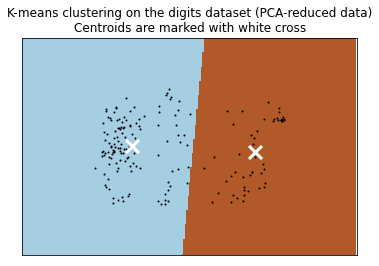

In [62]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainD).size

reduced_data = PCA(n_components=2).fit_transform(X_trainD)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

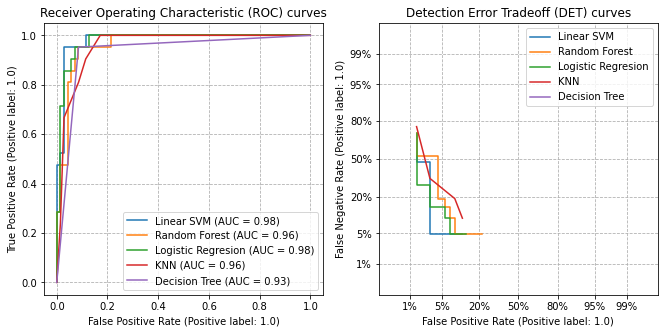

,Classifier,CA,AUC
0,Linear SVM,0.945055,0.947619
2,Logistic Regresion,0.934066,0.940476
4,Decision Tree,0.923077,0.933333
1,Random Forest,0.912088,0.876190
3,KNN,0.890110,0.861905


In [63]:
ClassifiersD = pd.DataFrame(columns=['Classifier', 'CA', 'AUC'])

classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Logistic Regresion" : LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": tree.DecisionTreeClassifier()
}

# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_trainD, y_trainD)
    score = accuracy_score(y_testD, clf.predict(X_testD))
    roc = roc_auc_score(y_testD, clf.predict(X_testD))
    row = {'Classifier': name, 'CA':score, 'AUC':roc}
    ClassifiersD = ClassifiersD.append(row, ignore_index= True)

    RocCurveDisplay.from_estimator(clf, X_testD, y_testD, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_testD, y_testD, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()
ClassifiersD.sort_values('AUC',ascending=[False])

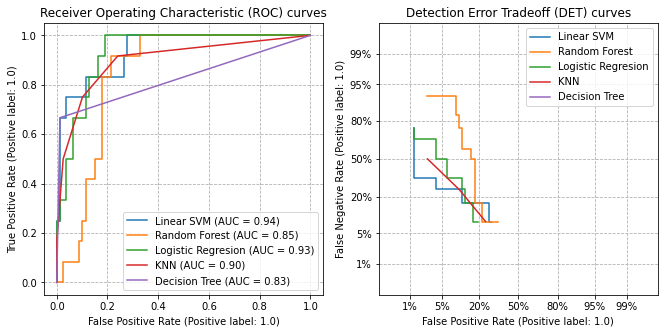

,Classifier,CA,AUC
4,Decision Tree,0.945055,0.827004
3,KNN,0.912088,0.737342
0,Linear SVM,0.912088,0.702004
2,Logistic Regresion,0.901099,0.625000
1,Random Forest,0.868132,0.500000


In [64]:
ClassifiersI = pd.DataFrame(columns=['Classifier', 'CA', 'AUC'])

classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Logistic Regresion" : LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": tree.DecisionTreeClassifier()
}

# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_trainI, y_trainI)
    score = accuracy_score(y_testI, clf.predict(X_testI))
    roc = roc_auc_score(y_testI, clf.predict(X_testI))
    row = {'Classifier': name, 'CA':score, 'AUC':roc}
    ClassifiersI = ClassifiersI.append(row, ignore_index= True)

    RocCurveDisplay.from_estimator(clf, X_testI, y_testI, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_testI, y_testI, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()
ClassifiersI.sort_values('AUC',ascending=[False])